In [1]:
# !pip install plotly
# !pip install matplotlib==3.5.0

In [2]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher
import seaborn as sns

In [3]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)


In [4]:
# def save_new_agg(data, name):
#     data_temp = data[((data['PROVINCE']=='LIMA') & (data['STATE']=='LIMA')) |
#                      (data['STATE']=='CALLAO')]
#     data_temp = data_temp[data_temp['YEAR']==2020].reset_index(drop=True)
#     data_temp['SECTOR'] = data_temp['SECTOR'].apply(lambda x: x if x == 'PRIVADO' else 'PUBLICO')
#     columns_ = data_temp['SECTOR'].unique()
#     data_temp = data_temp.groupby(['UBIGEO', 'DISTRICT','SECTOR','CO_IPRESS']).agg({ 'QTY_PEOPLE_SERVED': "sum"}).reset_index()
#     data_temp = data_temp.groupby(['UBIGEO', 'DISTRICT','SECTOR']).agg({ 'CO_IPRESS': "count"}).reset_index()
#     data_temp = data_temp.pivot(index =['UBIGEO', 'DISTRICT'], columns ='SECTOR')
#     data_temp.columns = data_temp.columns.droplevel()
#     data_temp = data_temp.reset_index()
#     data_temp.fillna(0, inplace = True)

#     data_temp['TOTAL'] = data_temp[columns_].sum(axis=1)
#     data_temp.to_csv(name, index = False)
#     return data_temp

In [5]:
all_data = pd.read_pickle('data/morbilidad_global.csv')
all_data['IS_LIMA'] = all_data['PROVINCE'].apply(lambda x : True if x=='LIMA' else False)

In [6]:
all_data.head()

,YEAR,MONTH,UBIGEO,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CO_IPRESS,NAME,...,AGE,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,CATEGORY2,DISEASE_GROUP,DATE,TYPE,DIGNOSTICO,IS_LIMA
0,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,7,R10.2,10,PELVIC AND PERINEAL PAIN,II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True
1,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,7,R10.4,11,UNIDENTIFIED,II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True
2,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,7,R11.X,3,UNIDENTIFIED,II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True
3,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,7,R16.0,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED",II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True
4,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,7,R42.X,1,UNIDENTIFIED,II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True


In [7]:
data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()
data_temp.head()

,DATE,sum,count
0,2015-01-01,6370,1010
1,2015-02-01,4303,837
2,2015-03-01,12568,917
3,2015-04-01,14378,1178
4,2015-05-01,16432,1284


C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/72860916.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


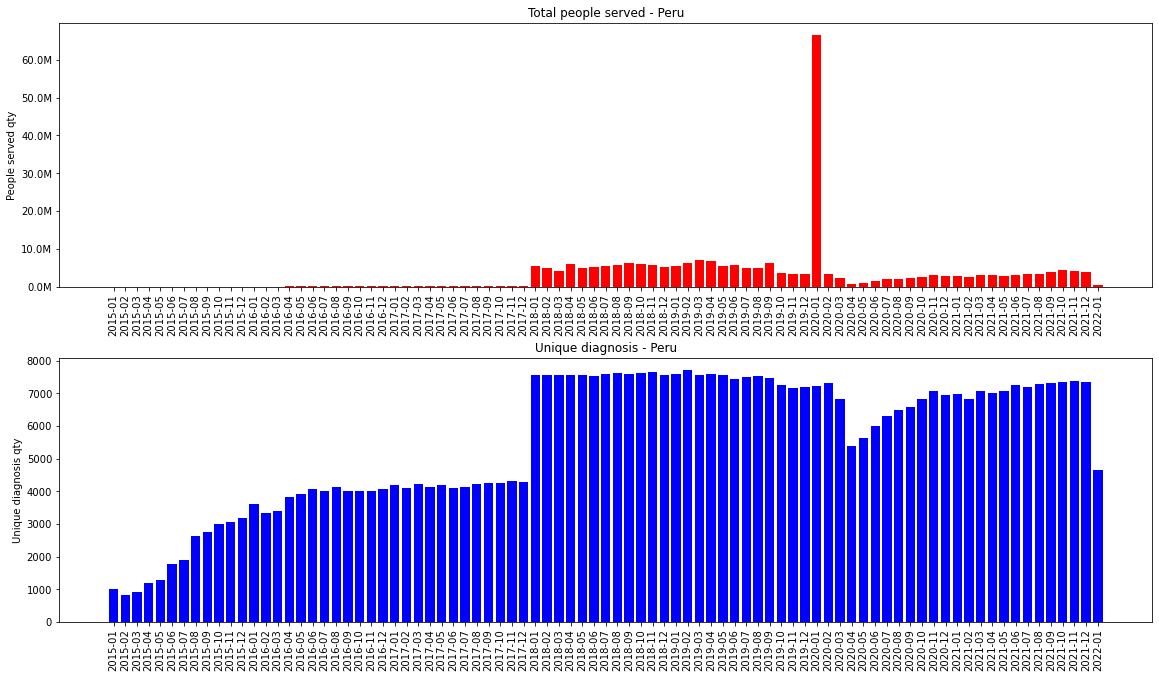

In [8]:
#fig, ax = plt.subplots(2, 1, figsize=(10,7))
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp['DATE'])]

y = list(data_temp['sum'])
ax[0].bar(x, y, color='red')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Peru')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp['count'])
ax[1].bar(x, y, color='blue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

In [9]:
all_data = all_data[all_data['YEAR']>=2018]

### Top 5 diagnosis 

#### ALL PERU

In [10]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

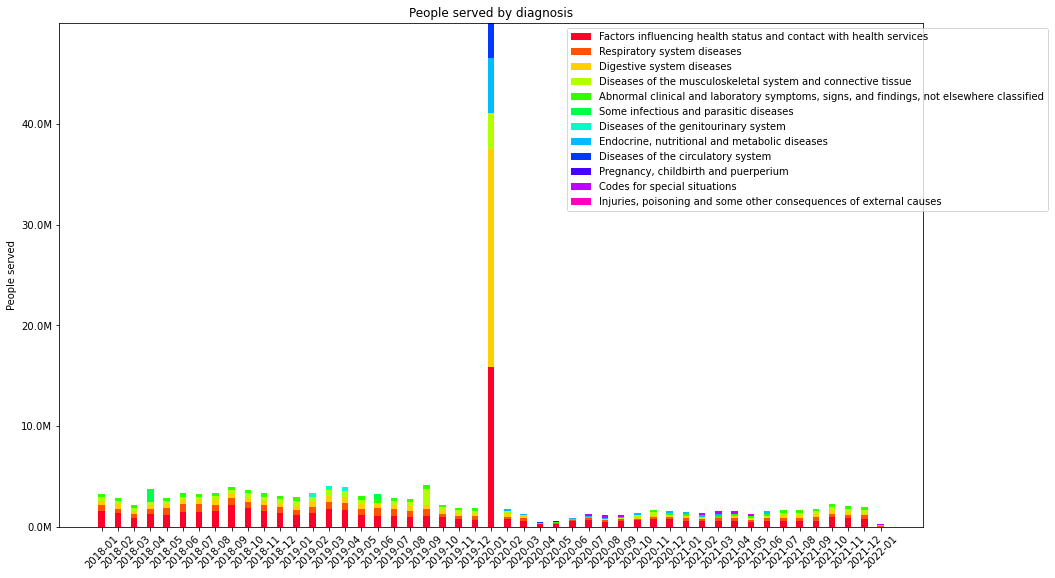

In [11]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

### Lima and Peru

In [12]:
PARAMETER = 'IS_LIMA'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

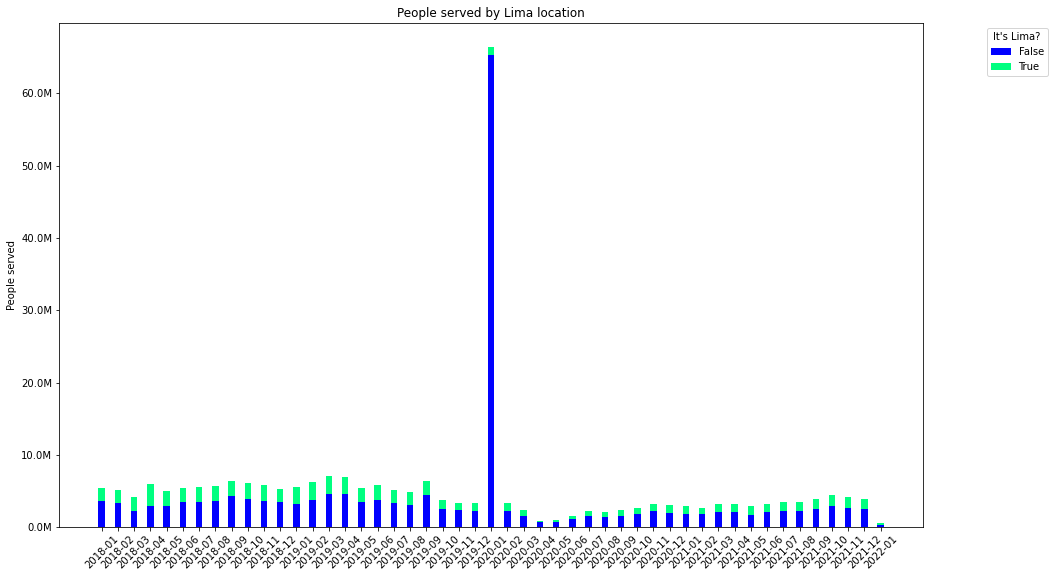

In [13]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "winter"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by Lima location')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1), title = "It's Lima?")
plt.show()

In [14]:
# ABC: verificar si HAY DUPLICADOS EN PROVIONCIAS EN ENERO 20

#### Lima vs Provinces (by year)

In [15]:
PARAMETER = 'IS_LIMA'

data_temp = all_data.groupby(['YEAR', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': 'sum'})
data_temp = data_temp.sort_values(by=['YEAR', PARAMETER]).reset_index()
data_temp = data_temp.pivot(index =['YEAR'], columns = PARAMETER)
data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)

data_temp.head()

IS_LIMA,False,True
YEAR,,
2018,40902183,24674247
2019,41352886,22395161
2020,82131111,8923410
2021,26539140,14856818
2022,288467,250119


<AxesSubplot:xlabel='YEAR'>

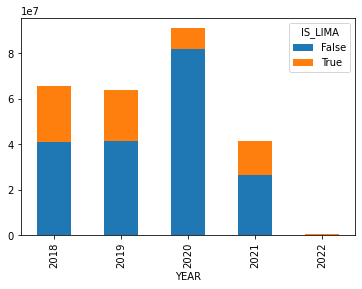

In [16]:

data_temp.plot(kind="bar", stacked=True)

### Births in Peru (by month)

In [17]:
PARAMETER = 'BIRTHS'

data_temp = all_data.copy()
data_temp['BIRTHS'] = data_temp['DISEASE_GROUP'].apply(lambda x : True if 'Pregnancy, childbirth and puerperium' == str(x) else False)

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

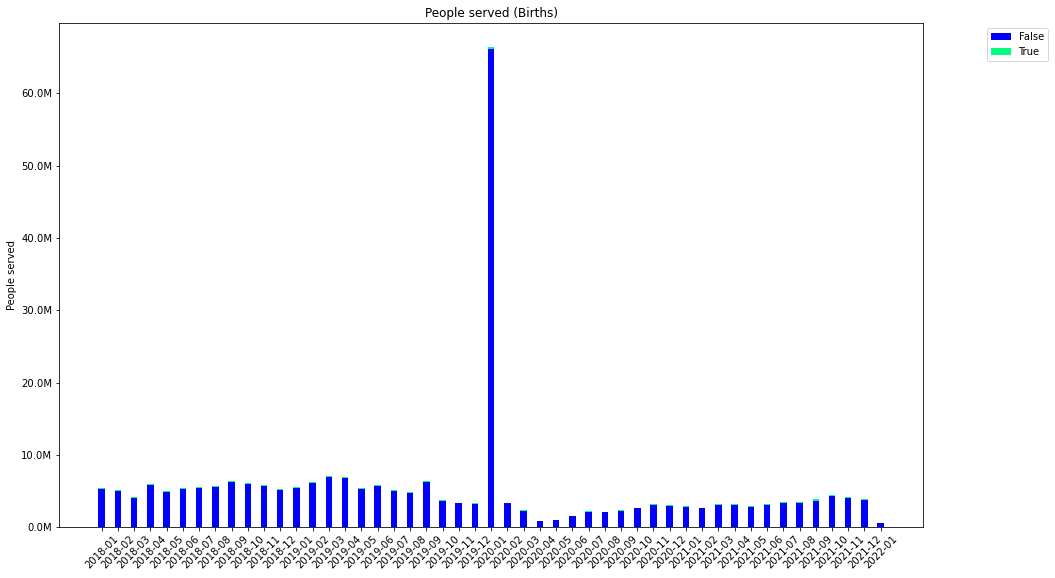

In [18]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "winter"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Births)')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

# Only Lima

In [19]:
all_data = all_data[all_data['IS_LIMA']==True]

In [20]:
data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp = data_temp.rename(columns={'sum': 'People_served', 'count': 'Unique_diagnosis'})

C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3573086791.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


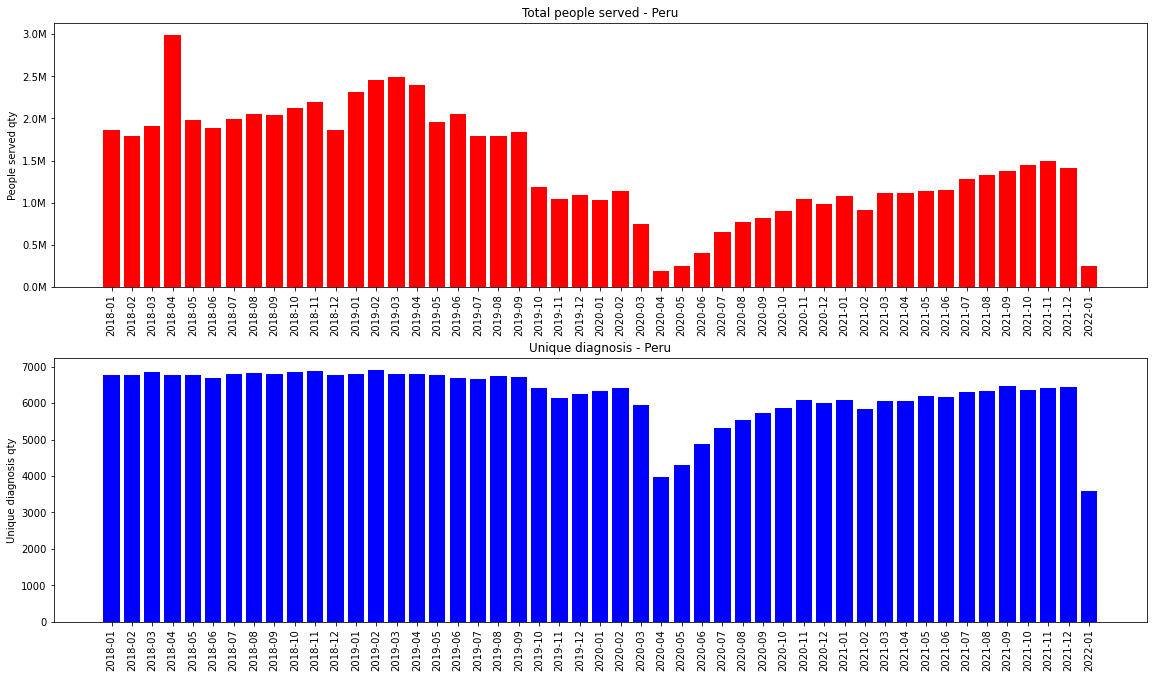

In [21]:
#fig, ax = plt.subplots(2, 1, figsize=(10,7))
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp['DATE'])]

y = list(data_temp['People_served'])
ax[0].bar(x, y, color='red')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Peru')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp['Unique_diagnosis'])
ax[1].bar(x, y, color='blue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

### Outlayers

C:\Users\johnk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johnk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


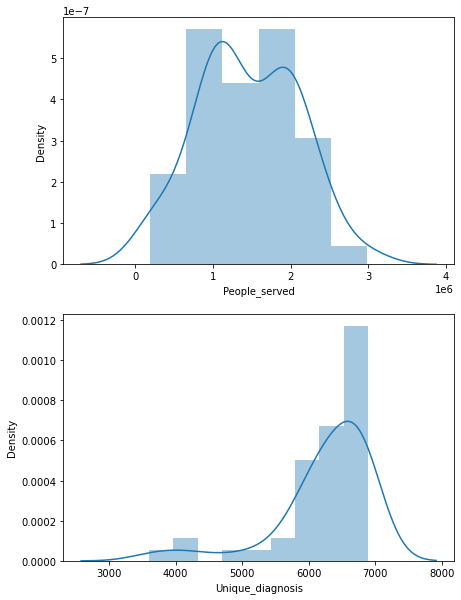

In [22]:
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
sns.distplot(data_temp['People_served'])
plt.subplot(2,1,2)
sns.distplot(data_temp['Unique_diagnosis'])
plt.show()

In [23]:
print(' People served')
people_served_max = data_temp['People_served'].mean() + 1*data_temp['People_served'].std()
people_served_min = data_temp['People_served'].mean() - 1*data_temp['People_served'].std()
print("   Highest allowed", people_served_max)
print("   Lowest allowed", people_served_min)
print()
print(' Unique diagnosis')
unique_diagnosis_max = data_temp['Unique_diagnosis'].mean() + 1*data_temp['Unique_diagnosis'].std()
unique_diagnosis_min = data_temp['Unique_diagnosis'].mean() - 1*data_temp['Unique_diagnosis'].std()
print("   Highest allowed", unique_diagnosis_max)
print("   Lowest allowed", unique_diagnosis_min)

data_temp['ps_out'] = data_temp['People_served'].apply(lambda x : 
                                                       0 if (people_served_min>x or
                                                                people_served_max<x)  
                                                       else x)
data_temp['ud_out'] = data_temp['Unique_diagnosis'].apply(lambda x : 
                                                       0 if (unique_diagnosis_min>x or
                                                                unique_diagnosis_max<x)  
                                                       else x )


 People served
   Highest allowed 2096462.6018830189
   Lowest allowed 805568.2144435119

 Unique diagnosis
   Highest allowed 6983.687152439192
   Lowest allowed 5500.4352965404


C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3451305518.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


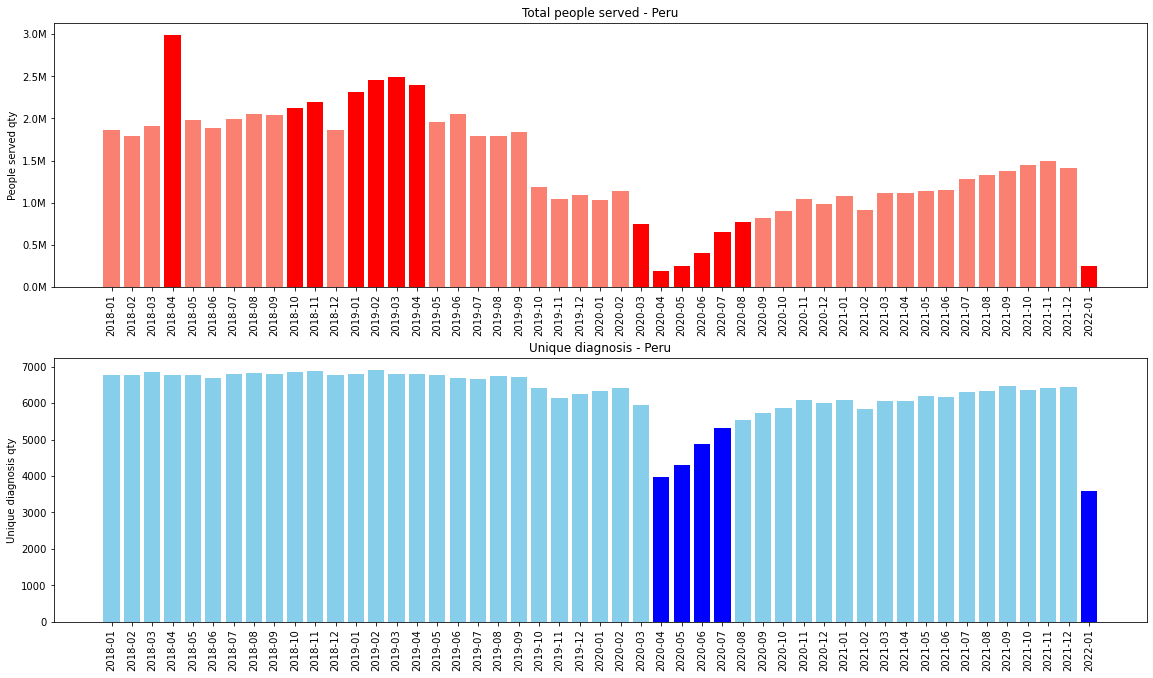

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp['DATE'])]

y = list(data_temp['People_served'])
ax[0].bar(x, y, color='red')
y = list(data_temp['ps_out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Peru')
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp['Unique_diagnosis'])
ax[1].bar(x, y, color='blue')
y = list(data_temp['ud_out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

### Forecast

### Top 10 diagnosis 

In [25]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

Sanity check for IHM using respiratory deseases. In IHM profile respiratory desease is 8% for Peru while in our Lima dataset we have arronf 9%


In [26]:
# solo enfermedades respiratorias

#top_df = top_df[top_df['DISEASE_GROUP']=='Respiratory system diseases']
#print(np.mean(top_df['PER']))

# ABC: Referencia - https://www.healthdata.org/peru


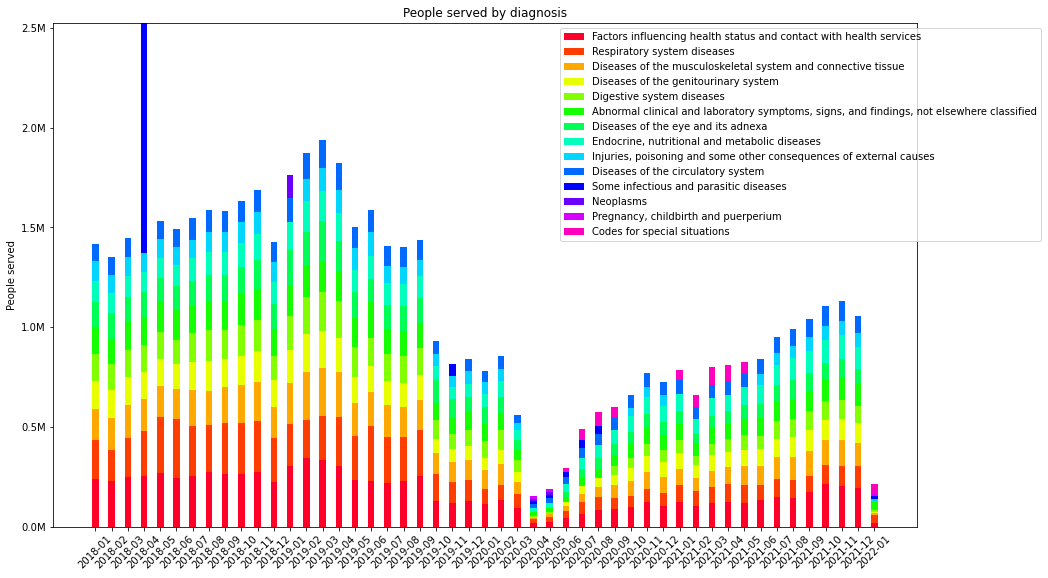

In [27]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

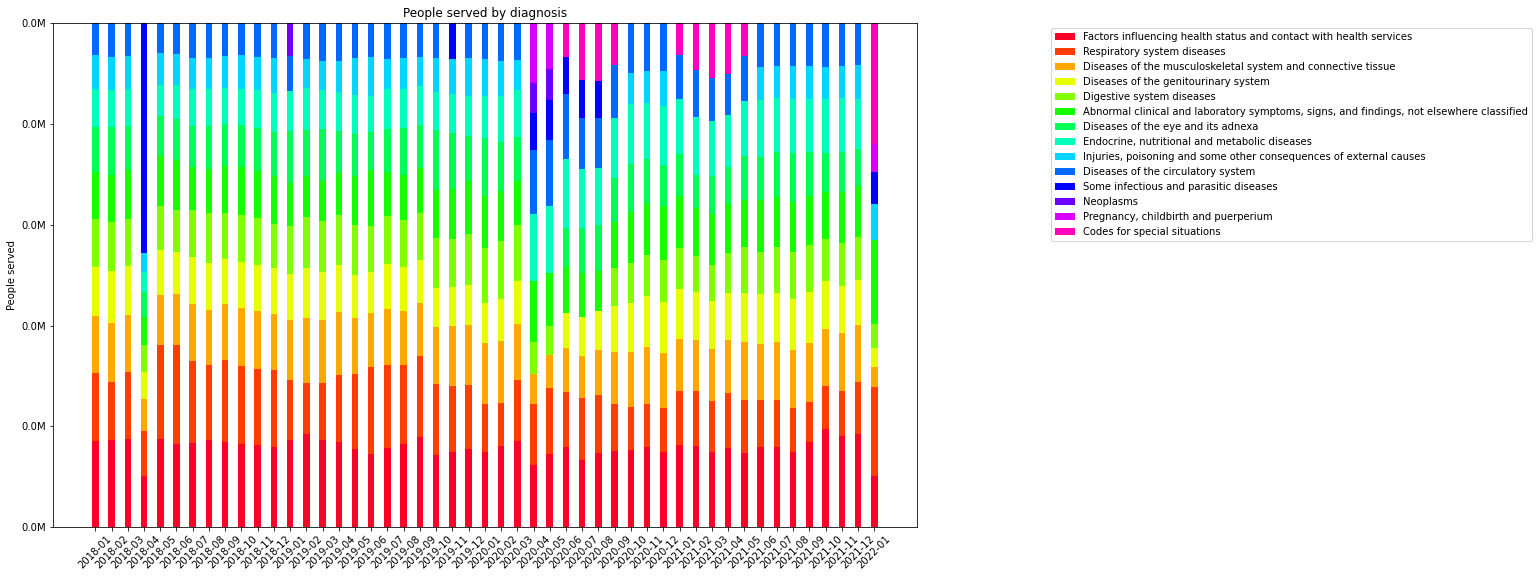

In [28]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['PER'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

### Births in Lima (by month)

Revisar datos de natalidad

In [29]:
PARAMETER = 'BIRTHS'

data_temp = all_data.copy()
data_temp['BIRTHS'] = data_temp['DISEASE_GROUP'].apply(lambda x : True if 'Pregnancy, childbirth and puerperium' == str(x) else False)

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

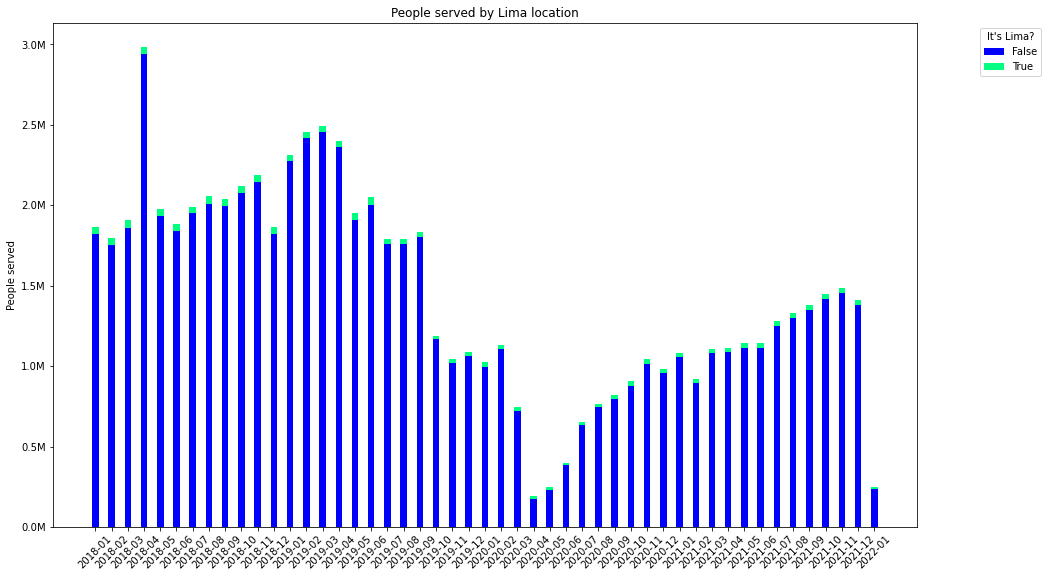

In [30]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "winter"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by Lima location')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1), title = "It's Lima?")
plt.show()

### Morbidity type

In [31]:
PARAMETER = 'TYPE'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

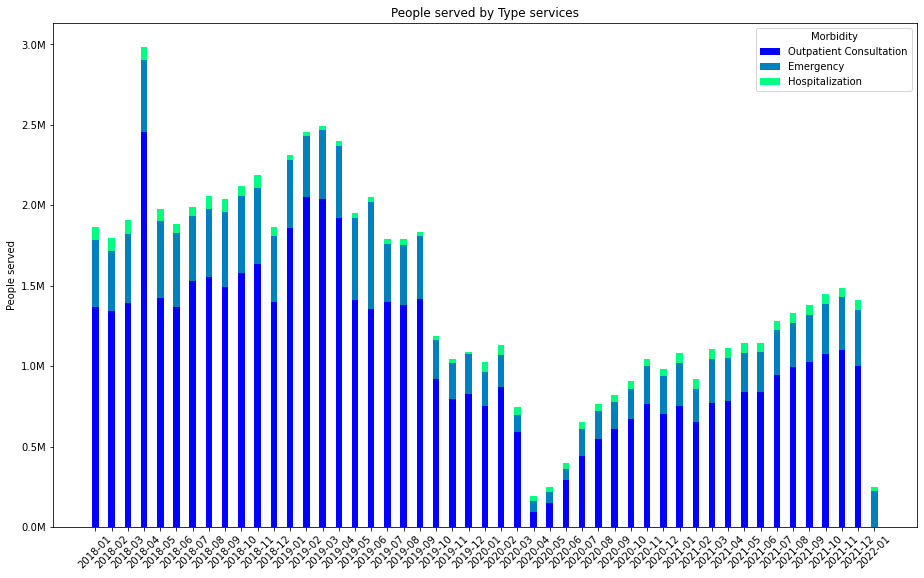

In [32]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "winter"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by Type services')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1., 1), title = "Morbidity")
plt.show()

### Diagnoses qty by hospitals and hospital category

In [33]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)

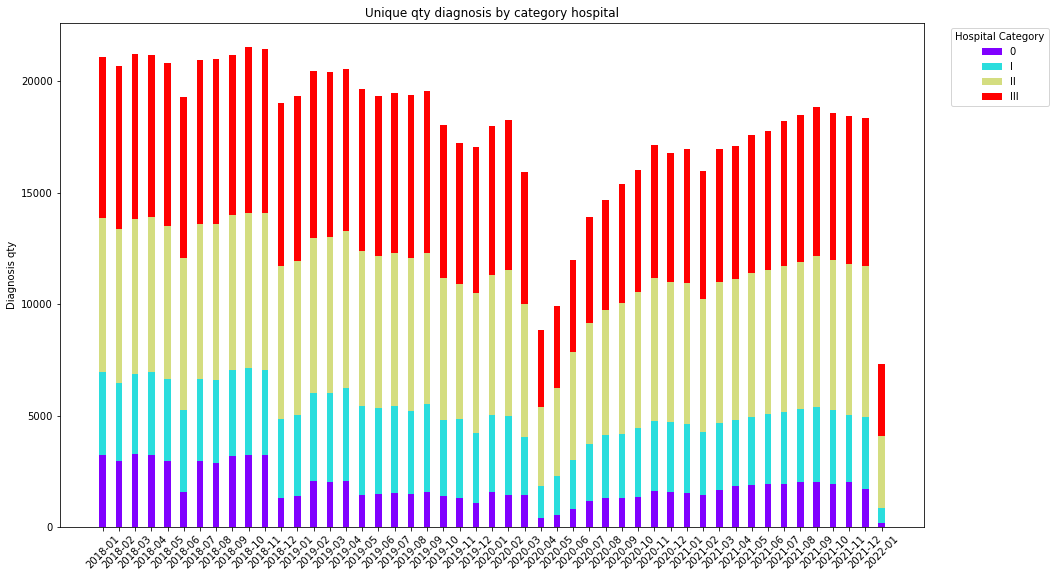

In [34]:
PARAMETER_COL = 'CATEGORY2'

category2 = data_temp[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp['DATE'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.40

name = "rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(category2)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for p in category2:
    temp_df = data_temp[data_temp[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('Diagnosis qty')
ax.set_title('Unique qty diagnosis by category hospital')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=category2, bbox_to_anchor = (1.15, 1), title = "Hospital Category")
plt.show()

### Diagnoses qty per hospital category (by year)

In [35]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['YEAR','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['YEAR','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['YEAR'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['YEAR']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['YEAR']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp = data_temp.sort_values(by=['YEAR','CATEGORY2'], ascending=True)

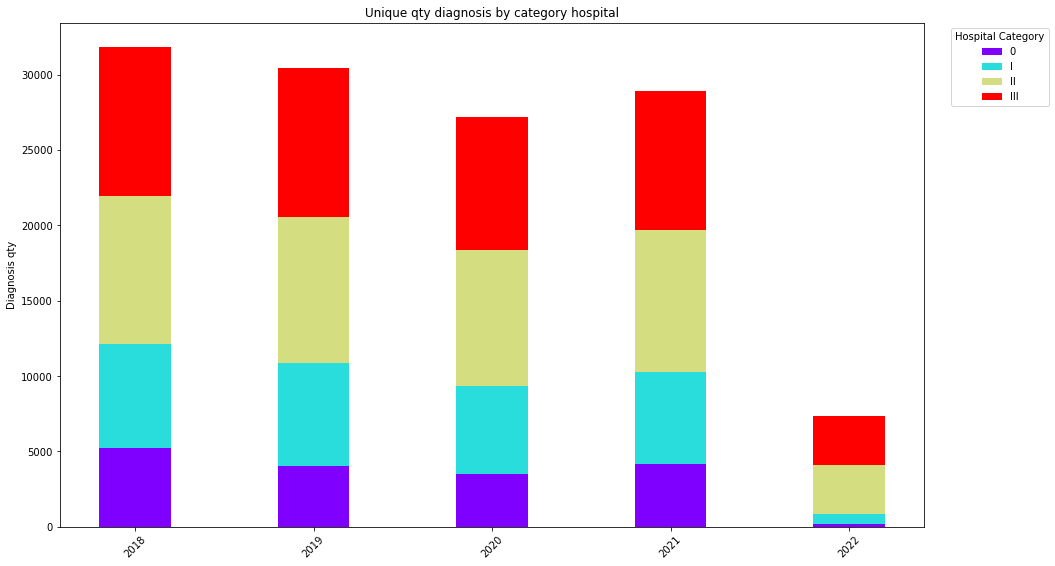

In [36]:
PARAMETER_COL = 'CATEGORY2'

category2 = data_temp[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp['YEAR'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.40

name = "rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(category2)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for p in category2:
    temp_df = data_temp[data_temp[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('Diagnosis qty')
ax.set_title('Unique qty diagnosis by category hospital')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=category2, bbox_to_anchor = (1.15, 1), title = "Hospital Category")
plt.show()

## People qty by hospitals and hospital category

In [76]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
# data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
# data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)

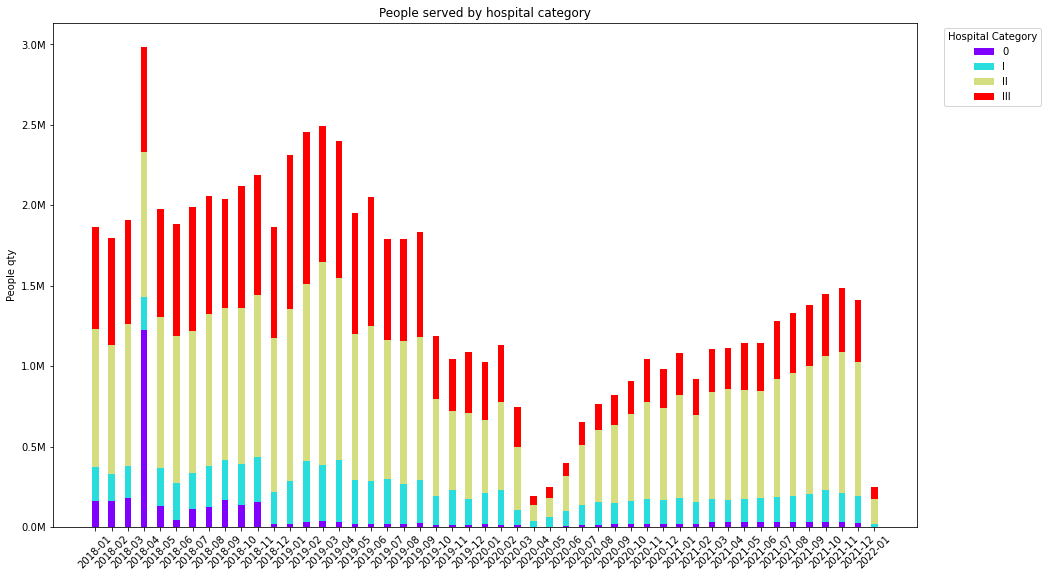

In [77]:
PARAMETER_COL = 'CATEGORY2'

category2 = data_temp[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp['DATE'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.40

name = "rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(category2)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for p in category2:
    temp_df = data_temp[data_temp[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People qty')
ax.set_title('People served by hospital category')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=category2, bbox_to_anchor = (1.15, 1), title = "Hospital Category")
plt.show()

In [78]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp_dq = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)
data_temp_dq = data_temp_dq.rename(columns={"QTY_PEOPLE_SERVED": "Diagnosis qty"})

data_temp = all_data[all_data['CATEGORY2']!='ABC']
# data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
# data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp_ps = data_temp.sort_values(by=['DATE','CATEGORY2'], ascending=True)
data_temp_ps = data_temp_ps.rename(columns={"QTY_PEOPLE_SERVED": "People served"})

C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3555594971.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_p['out'] = data_temp_p['People served'].apply(lambda x :
C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3555594971.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x :
C:\Users\johnk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a 

<AxesSubplot:xlabel='Diagnosis qty', ylabel='Density'>

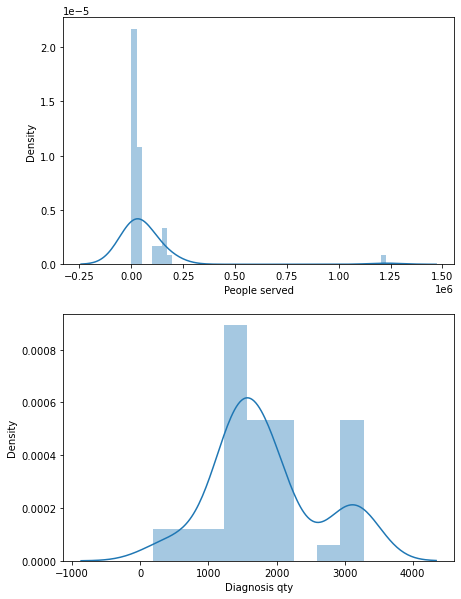

In [79]:
#### Categoria 0

Ctgy_std = '0'
data_temp_p = data_temp_ps[data_temp_ps['CATEGORY2']==Ctgy_std]
data_temp_d = data_temp_dq[data_temp_dq['CATEGORY2']==Ctgy_std]


people_served_max = data_temp_p['People served'].mean() + 1*data_temp_p['People served'].std()
people_served_min = data_temp_p['People served'].mean() - 1*data_temp_p['People served'].std()
unique_diagnosis_max = data_temp_d['Diagnosis qty'].mean() + 1*data_temp_d['Diagnosis qty'].std()
unique_diagnosis_min = data_temp_d['Diagnosis qty'].mean() - 1*data_temp_d['Diagnosis qty'].std()

data_temp_p['out'] = data_temp_p['People served'].apply(lambda x : 
                                                           0 if (people_served_min>x or
                                                                 people_served_max<x)
                                                           else x)

data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x : 
                                                           0 if (unique_diagnosis_min>x or
                                                                 unique_diagnosis_max<x)
                                                           else x)

plt.figure(figsize=(7,10))

plt.subplot(2,1,1)
sns.distplot(data_temp_p['People served'])
plt.subplot(2,1,2)
sns.distplot(data_temp_d['Diagnosis qty'])

C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3086659864.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


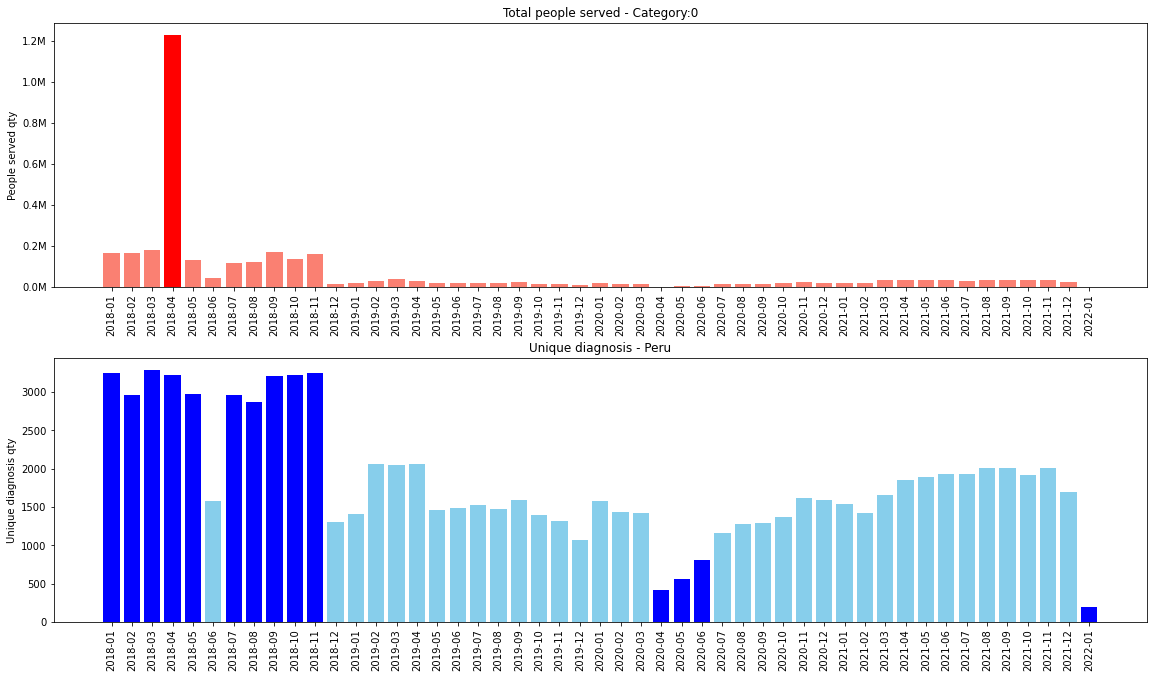

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp_p['DATE'])]

y = list(data_temp_p['People served'])
ax[0].bar(x, y, color='red')
y = list(data_temp_p['out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Category:'+Ctgy_std)
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp_d['Diagnosis qty'])
ax[1].bar(x, y, color='blue')
y = list(data_temp_d['out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

#### Diagnosis to Cat 0

In [122]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)


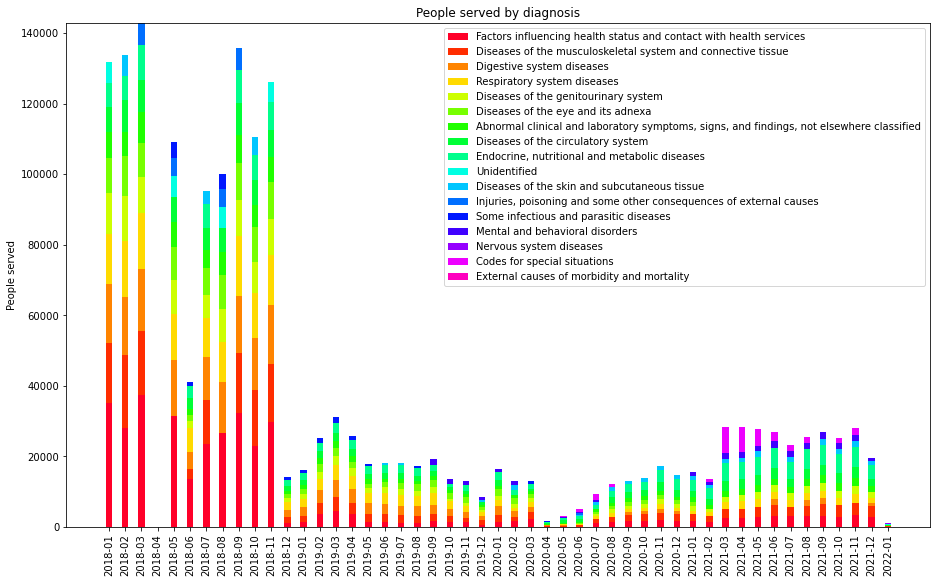

In [126]:

top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.0, 1))
plt.show()

#### Diagnosis to Cat 0 - sector2

In [133]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[data_temp['SECTOR']=='PRIVADO']

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

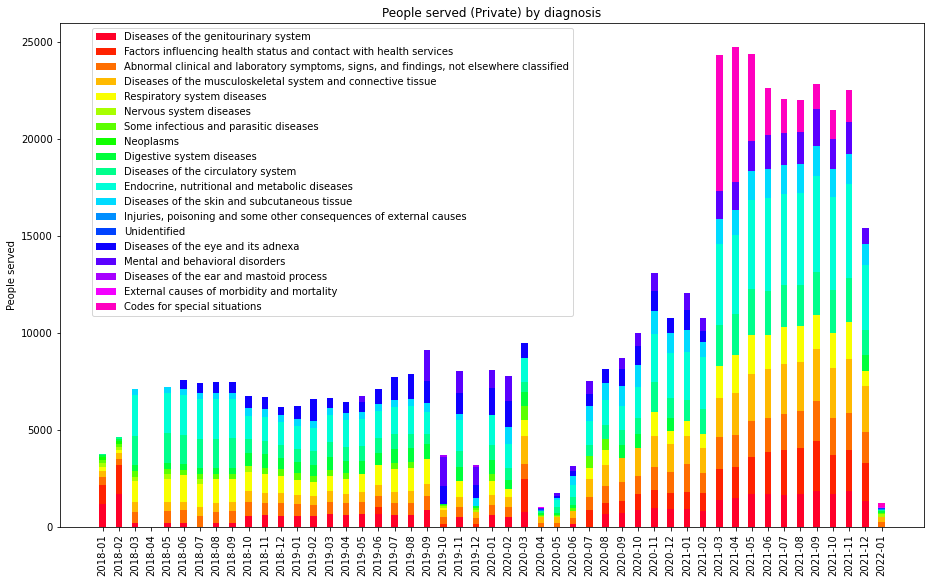

In [143]:
top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Private) by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (0.6, 1))
plt.show()

In [157]:
data_temp = all_data[all_data['CATEGORY2']==Ctgy_std]
data_temp = data_temp[~(data_temp['SECTOR']=='PRIVADO')]

PARAMETER = 'DISEASE_GROUP'

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    #temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

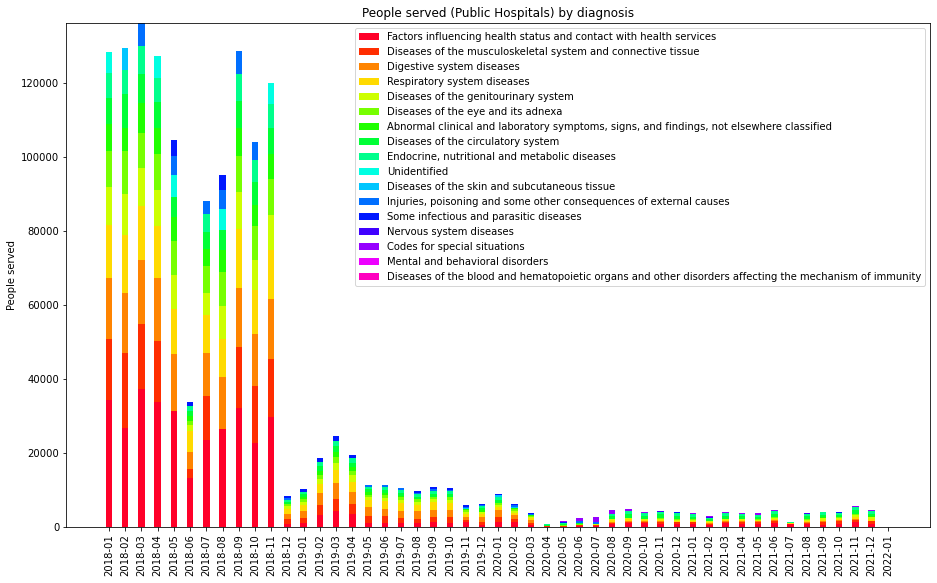

In [159]:
# top_df['PER'] =top_df['PER'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)
# top_df['QTY_PEOPLE_SERVED'] = top_df['QTY_PEOPLE_SERVED'].mask((top_df['DATE'].dt.year==2018) & (top_df['DATE'].dt.month==4), 0)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

name = "gist_rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(diagnosis)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served (Public Hospitals) by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=90)
#ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1., 1))
plt.show()

C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/1081730851.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_p['out'] = data_temp_p['People served'].apply(lambda x :
C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/1081730851.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x :
C:\Users\johnk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a 

<AxesSubplot:xlabel='Diagnosis qty', ylabel='Density'>

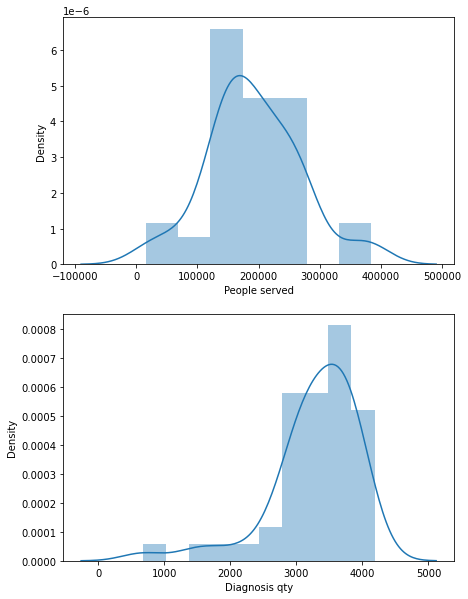

In [42]:
#### Categoria 1

Ctgy_std = 'I'
data_temp_p = data_temp_ps[data_temp_ps['CATEGORY2']==Ctgy_std]
data_temp_d = data_temp_dq[data_temp_dq['CATEGORY2']==Ctgy_std]


people_served_max = data_temp_p['People served'].mean() + 1*data_temp_p['People served'].std()
people_served_min = data_temp_p['People served'].mean() - 1*data_temp_p['People served'].std()
unique_diagnosis_max = data_temp_d['Diagnosis qty'].mean() + 1*data_temp_d['Diagnosis qty'].std()
unique_diagnosis_min = data_temp_d['Diagnosis qty'].mean() - 1*data_temp_d['Diagnosis qty'].std()

data_temp_p['out'] = data_temp_p['People served'].apply(lambda x : 
                                                           0 if (people_served_min>x or
                                                                 people_served_max<x)
                                                           else x)

data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x : 
                                                           0 if (unique_diagnosis_min>x or
                                                                 unique_diagnosis_max<x)
                                                           else x)

plt.figure(figsize=(7,10))

plt.subplot(2,1,1)
sns.distplot(data_temp_p['People served'])
plt.subplot(2,1,2)
sns.distplot(data_temp_d['Diagnosis qty'])

C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3086659864.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


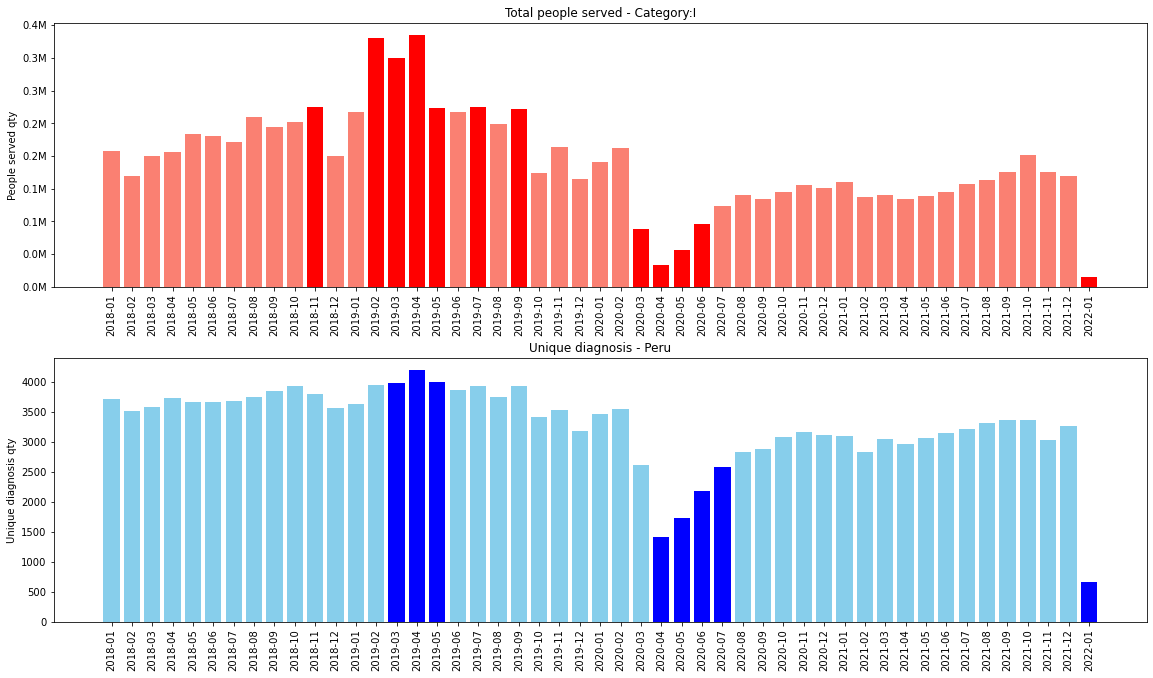

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp_p['DATE'])]

y = list(data_temp_p['People served'])
ax[0].bar(x, y, color='red')
y = list(data_temp_p['out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Category:'+Ctgy_std)
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp_d['Diagnosis qty'])
ax[1].bar(x, y, color='blue')
y = list(data_temp_d['out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/1439161339.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_p['out'] = data_temp_p['People served'].apply(lambda x :
C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/1439161339.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x :
C:\Users\johnk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a 

<AxesSubplot:xlabel='Diagnosis qty', ylabel='Density'>

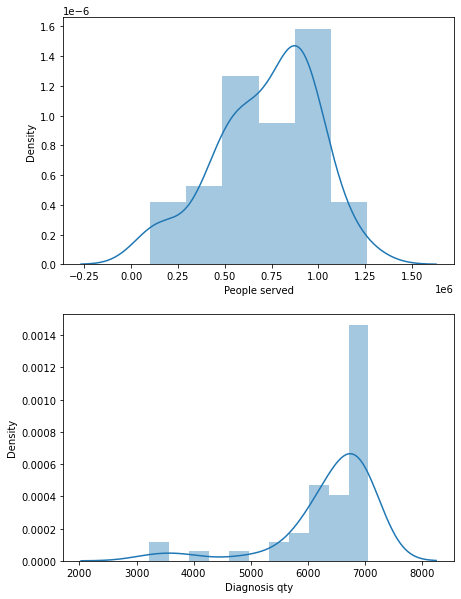

In [44]:
#### Categoria 2

Ctgy_std = 'II'
data_temp_p = data_temp_ps[data_temp_ps['CATEGORY2']==Ctgy_std]
data_temp_d = data_temp_dq[data_temp_dq['CATEGORY2']==Ctgy_std]


people_served_max = data_temp_p['People served'].mean() + 1*data_temp_p['People served'].std()
people_served_min = data_temp_p['People served'].mean() - 1*data_temp_p['People served'].std()
unique_diagnosis_max = data_temp_d['Diagnosis qty'].mean() + 1*data_temp_d['Diagnosis qty'].std()
unique_diagnosis_min = data_temp_d['Diagnosis qty'].mean() - 1*data_temp_d['Diagnosis qty'].std()

data_temp_p['out'] = data_temp_p['People served'].apply(lambda x : 
                                                           0 if (people_served_min>x or
                                                                 people_served_max<x)
                                                           else x)

data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x : 
                                                           0 if (unique_diagnosis_min>x or
                                                                 unique_diagnosis_max<x)
                                                           else x)

plt.figure(figsize=(7,10))

plt.subplot(2,1,1)
sns.distplot(data_temp_p['People served'])
plt.subplot(2,1,2)
sns.distplot(data_temp_d['Diagnosis qty'])

C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3086659864.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


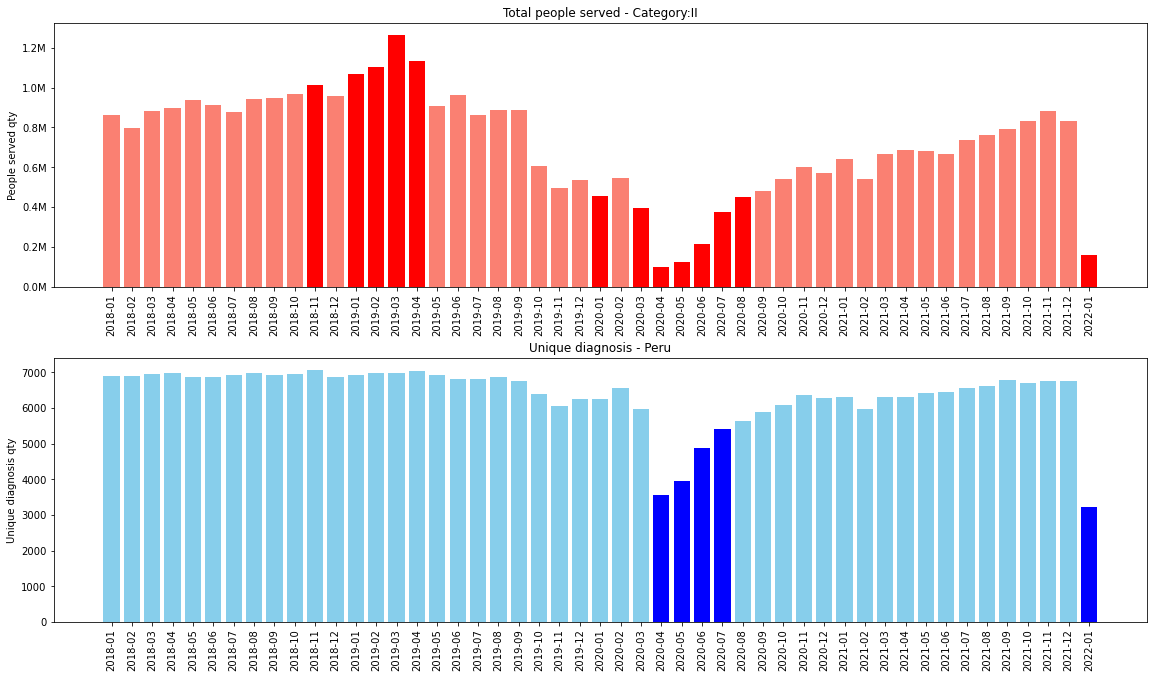

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp_p['DATE'])]

y = list(data_temp_p['People served'])
ax[0].bar(x, y, color='red')
y = list(data_temp_p['out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Category:'+Ctgy_std)
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp_d['Diagnosis qty'])
ax[1].bar(x, y, color='blue')
y = list(data_temp_d['out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3905900440.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_p['out'] = data_temp_p['People served'].apply(lambda x :
C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3905900440.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x :
C:\Users\johnk\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a 

<AxesSubplot:xlabel='Diagnosis qty', ylabel='Density'>

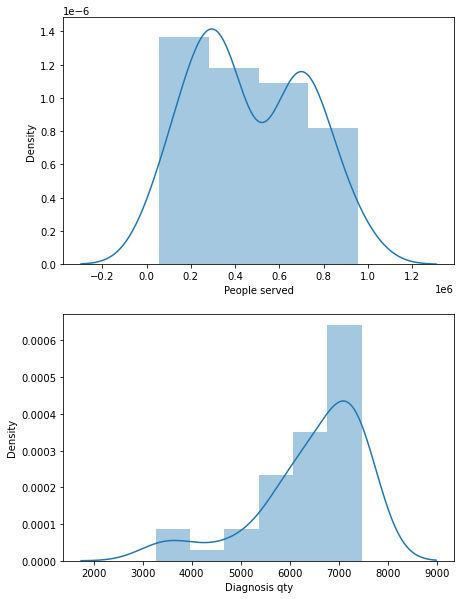

In [46]:
#### Categoria 3

Ctgy_std = 'III'
data_temp_p = data_temp_ps[data_temp_ps['CATEGORY2']==Ctgy_std]
data_temp_d = data_temp_dq[data_temp_dq['CATEGORY2']==Ctgy_std]


people_served_max = data_temp_p['People served'].mean() + 1*data_temp_p['People served'].std()
people_served_min = data_temp_p['People served'].mean() - 1*data_temp_p['People served'].std()
unique_diagnosis_max = data_temp_d['Diagnosis qty'].mean() + 1*data_temp_d['Diagnosis qty'].std()
unique_diagnosis_min = data_temp_d['Diagnosis qty'].mean() - 1*data_temp_d['Diagnosis qty'].std()

data_temp_p['out'] = data_temp_p['People served'].apply(lambda x : 
                                                           0 if (people_served_min>x or
                                                                 people_served_max<x)
                                                           else x)

data_temp_d['out'] = data_temp_d['Diagnosis qty'].apply(lambda x : 
                                                           0 if (unique_diagnosis_min>x or
                                                                 unique_diagnosis_max<x)
                                                           else x)

plt.figure(figsize=(7,10))

plt.subplot(2,1,1)
sns.distplot(data_temp_p['People served'])
plt.subplot(2,1,2)
sns.distplot(data_temp_d['Diagnosis qty'])

C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3086659864.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


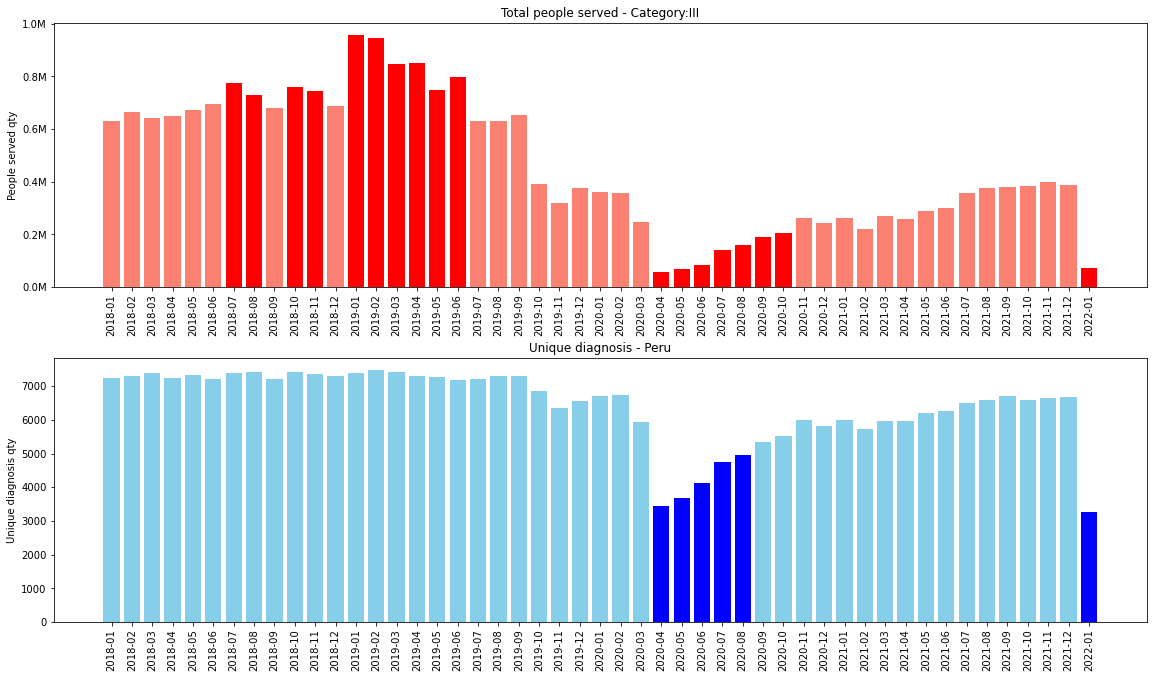

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(17,10))
fig.tight_layout(pad=5.0)

x = [str(item)[:7] for item in np.unique(data_temp_p['DATE'])]

y = list(data_temp_p['People served'])
ax[0].bar(x, y, color='red')
y = list(data_temp_p['out'])
ax[0].bar(x, y, color='salmon')
ax[0].set_ylabel('People served qty')
ax[0].set_title('Total people served - Category:'+Ctgy_std)
ax[0].set_xticks(x)
ax[0].set_xticklabels(x, rotation=90)
ax[0].yaxis.set_major_formatter(millions)

y = list(data_temp_d['Diagnosis qty'])
ax[1].bar(x, y, color='blue')
y = list(data_temp_d['out'])
ax[1].bar(x, y, color='skyblue')
ax[1].set_ylabel('Unique diagnosis qty')
ax[1].set_title('Unique diagnosis - Peru')
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, rotation=90)

fig.show()

### People qty by hospitals and hospital category (YEAR)

In [48]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
# data_temp = data_temp.groupby(['DATE','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
# data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['YEAR','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['YEAR'].unique()
category2 = data_temp['CATEGORY2'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['YEAR']==date]
    category2_temp = list(set(category2) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category2_temp, columns =['CATEGORY2'])
    temp_df['YEAR']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])

data_temp = data_temp.sort_values(by=['YEAR','CATEGORY2'], ascending=True)

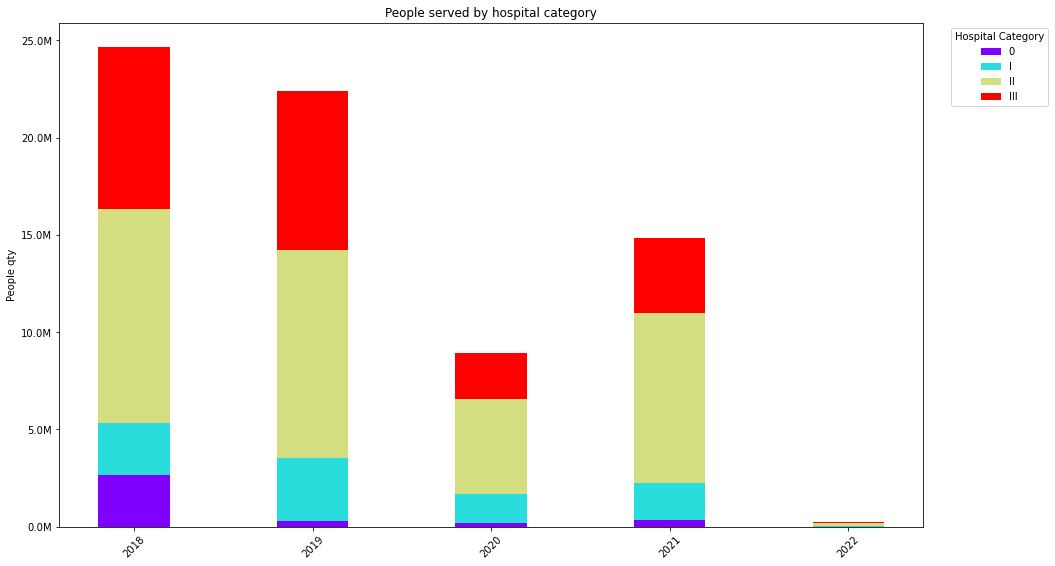

In [49]:
PARAMETER_COL = 'CATEGORY2'

category2 = data_temp[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp['YEAR'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.40

name = "rainbow"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors = cmap(np.linspace(0, 1, len(category2)))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for p in category2:
    temp_df = data_temp[data_temp[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=colors[i])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People qty')
ax.set_title('People served by hospital category')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=category2, bbox_to_anchor = (1.15, 1), title = "Hospital Category")
plt.show()

### Graph by gender and hospital category

In [50]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','SEX','CATEGORY2','DIAGNOSIS_ID']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE','SEX','CATEGORY2']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
category = data_temp['CATEGORY2'].unique()

data_temp_m = data_temp[data_temp['SEX']=='M']
data_temp_f = data_temp[data_temp['SEX']=='F']

for date in date_uniques:
    temp_df = data_temp_m[data_temp_m['DATE']==date]
    category_temp = list(set(category) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_m = pd.concat([data_temp_m, temp_df])

for date in date_uniques:
    temp_df = data_temp_f[data_temp_f['DATE']==date]
    category_temp = list(set(category) - set(temp_df['CATEGORY2'].values))
    temp_df = pd.DataFrame(category_temp, columns =['CATEGORY2'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_f = pd.concat([data_temp_f, temp_df])

data_temp_m = data_temp_m.sort_values(by=['DATE','CATEGORY2'], ascending=True)
data_temp_f = data_temp_f.sort_values(by=['DATE','CATEGORY2'], ascending=True)

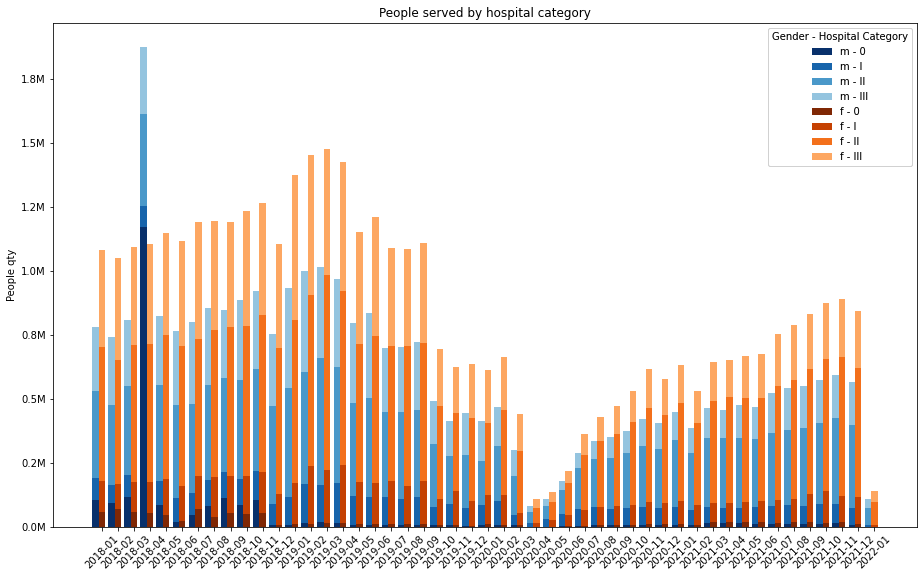

In [51]:
PARAMETER_COL = 'CATEGORY2'

category_m = data_temp_m[PARAMETER_COL].unique()
category_f = data_temp_f[PARAMETER_COL].unique()
x_element = [str(item)[:7] for item in np.unique(data_temp_m['DATE'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.5*0.8

name = "Blues"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors_m = cmap(list(reversed(np.linspace(0, 1, len(category_m)+2))))

name = "Oranges"
cmap = cm.get_cmap(name, 256)  # type: matplotlib.colors.ListedColormap
colors_f = cmap(list(reversed(np.linspace(0, 1, len(category_f)+2))))

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

tags =[]
values_temp_m = 0
i = 0
for p in category_m:
    tag = 'm - '+p
    temp_df = data_temp_m[data_temp_m[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind - width, values, width, bottom=values_temp_m, color=colors_m[i])
    values_temp_m = values_temp_m + values
    i+=1
    tags.append(tag)
    
values_temp_f = 0
i = 0
for p in category_f:
    tag = 'f - '+p
    temp_df = data_temp_f[data_temp_f[PARAMETER_COL]==p]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind + 0, values, width, bottom=values_temp_f, color=colors_f[i])
    values_temp_f = values_temp_f + values
    i+=1
    tags.append(tag)

ax.set_ylabel('People qty')
ax.set_title('People served by hospital category')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)



# legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc=1)
# legend2 = plt.legend([lines[i] for i in [2,3]],['manual label 3','manual label 4'], loc=4)
# plt.gca().add_artist(legend1)

# legend1 = ax.legend(labels=category_m, color = colors_f, bbox_to_anchor = (1.0, 1), title = "Hospital Category - male  ")
# legend2 = ax.legend(labels=category_f, bbox_to_anchor = (1, 0.8), title = "Hospital Category - female")
# ax.add_artist(legend1)
# ax.add_artist(legend2)

legend1 = ax.legend(labels=tags, bbox_to_anchor = (1.0, 1), title = "Gender - Hospital Category")
ax.add_artist(legend1)

plt.show()

### Proyeccion del sistemas por genero

In [52]:
data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','SEX']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
data_temp_m = data_temp[data_temp['SEX']=='M']
data_temp_f = data_temp[data_temp['SEX']=='F']


dimension = data_temp_m['SEX'].unique()
for date in date_uniques:
    temp_df = data_temp_m[data_temp_m['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SEX'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SEX'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_m = pd.concat([data_temp_m, temp_df])

    
dimension = data_temp_f['SEX'].unique()
for date in date_uniques:
    temp_df = data_temp_f[data_temp_f['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['SEX'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['SEX'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp_f = pd.concat([data_temp_f, temp_df])

data_temp_m = data_temp_m.sort_values(by=['DATE','SEX'], ascending=True)
data_temp_f = data_temp_f.sort_values(by=['DATE','SEX'], ascending=True)

In [53]:
labels = [str(x)[:7] for x in date_uniques]
men_means = list(data_temp_m['QTY_PEOPLE_SERVED'])
women_means = list(data_temp_f['QTY_PEOPLE_SERVED'])

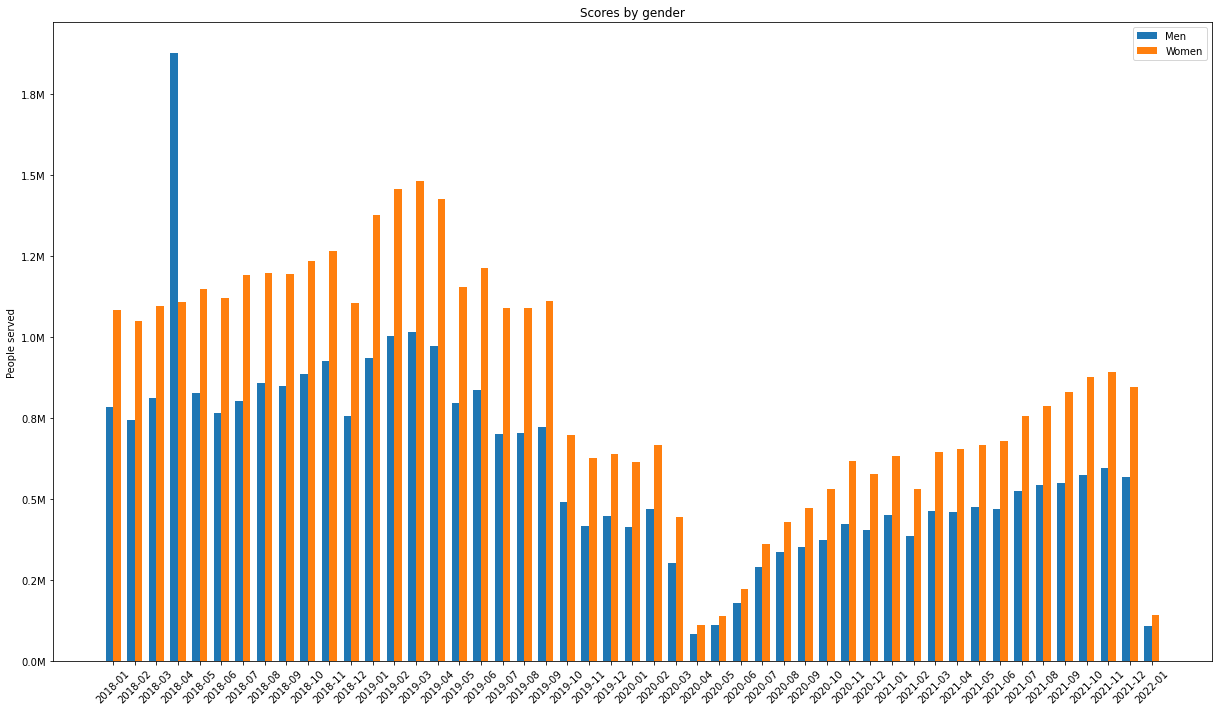

In [54]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

#fig, ax = plt.subplots()
fig, ax = plt.subplots(1, 1, figsize=(17,10))
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('People served')
ax.set_title('Scores by gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

ax.yaxis.set_major_formatter(millions)

plt.show()

### Dental diagnosis

In [55]:
data_temp = all_data
data_temp['DENTAL_DISEASE'] = data_temp['DIAGNOSIS_ID'].str.contains('^K')

data_temp = data_temp.groupby(['YEAR','DENTAL_DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.sort_values(by=['YEAR', 'DENTAL_DISEASE']).reset_index()
data_temp = data_temp.pivot(index =['YEAR'], columns = 'DENTAL_DISEASE')
data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)
data_temp.head()

DENTAL_DISEASE,False,True
YEAR,,
2018,22995488,1678759
2019,20709480,1685681
2020,8351370,572040
2021,13923488,933330
2022,239586,10533


Text(0.5, 1.0, 'Qty of dental diseases by year')

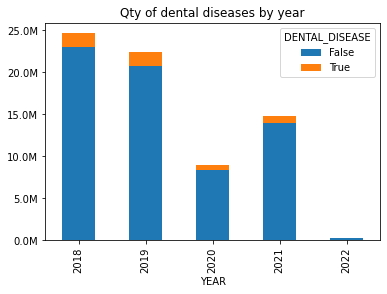

In [56]:
abc = data_temp.plot(kind="bar", stacked=True)
abc.yaxis.set_major_formatter(millions)
abc.set_title('Qty of dental diseases by year')

In [57]:
data_temp = data_temp.reset_index()
data_temp['total'] = data_temp[False] + data_temp[True]
data_temp[False] = data_temp[False]/data_temp['total']
data_temp[True] = data_temp[True]/data_temp['total']
del data_temp['total']

data_temp = data_temp.set_index('YEAR')

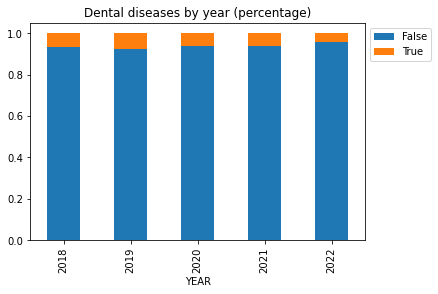

In [58]:
abc = data_temp.plot(kind="bar", stacked=True)
#abc.yaxis.set_major_formatter(millions)
abc.set_title('Dental diseases by year (percentage)')

abc.legend(bbox_to_anchor = (1.0, 1))

### Conteo de diagnosticos por mes jensenshannon_dis

In [59]:

# DISEASE_GROUP, DIAGNOSIS_ID

data_temp = all_data[all_data['CATEGORY2']!='ABC']
data_temp = data_temp.groupby(['DATE','DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

date_uniques = data_temp['DATE'].unique()
dimension = data_temp['DISEASE_GROUP'].unique()

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    dimension_temp = list(set(dimension) - set(temp_df['DISEASE_GROUP'].values))
    temp_df = pd.DataFrame(dimension_temp, columns =['DISEASE_GROUP'])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    data_temp = pd.concat([data_temp, temp_df])
    
data_temp = data_temp.sort_values(by=['DATE','DISEASE_GROUP'], ascending=True)

In [60]:
data_temp.head()

,DATE,DISEASE_GROUP,QTY_PEOPLE_SERVED
0,2018-01-01,"Abnormal clinical and laboratory symptoms, sig...",132370
1,2018-01-01,Codes for special situations,103
2,2018-01-01,"Congenital malformations, deformities and chro...",14966
3,2018-01-01,Digestive system diseases,136278
4,2018-01-01,Diseases of the blood and hematopoietic organs...,16710


In [61]:
diseases_dim = []
diseases_name = []
for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    diseases_name.append(list(temp_df['DISEASE_GROUP']))
    diseases_dim.append(list(temp_df['QTY_PEOPLE_SERVED']))

In [62]:
from scipy.spatial import distance

jensenshannon_dis = []
for i in range(len(date_uniques)-1):
    i_date = str(date_uniques[i])[:7]
    f_date = str(date_uniques[i+1])[:7]
    dis = distance.jensenshannon(diseases_dim[i], diseases_dim[i+1])
    jensenshannon_dis.append([i_date, f_date, dis])
    
jensenshannon_dis = pd.DataFrame(jensenshannon_dis,
                                 columns =['date_i', 'date_f', 'jensenshannon'])

In [63]:
jensenshannon_dis.head()

,date_i,date_f,jensenshannon
0,2018-01,2018-02,0.024313
1,2018-02,2018-03,0.022876
2,2018-03,2018-04,0.310843
3,2018-04,2018-05,0.318266
4,2018-05,2018-06,0.024077


C:\Users\johnk\AppData\Local\Temp/ipykernel_14000/3424621862.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(jensenshannon_dis['date_f'], rotation=45)


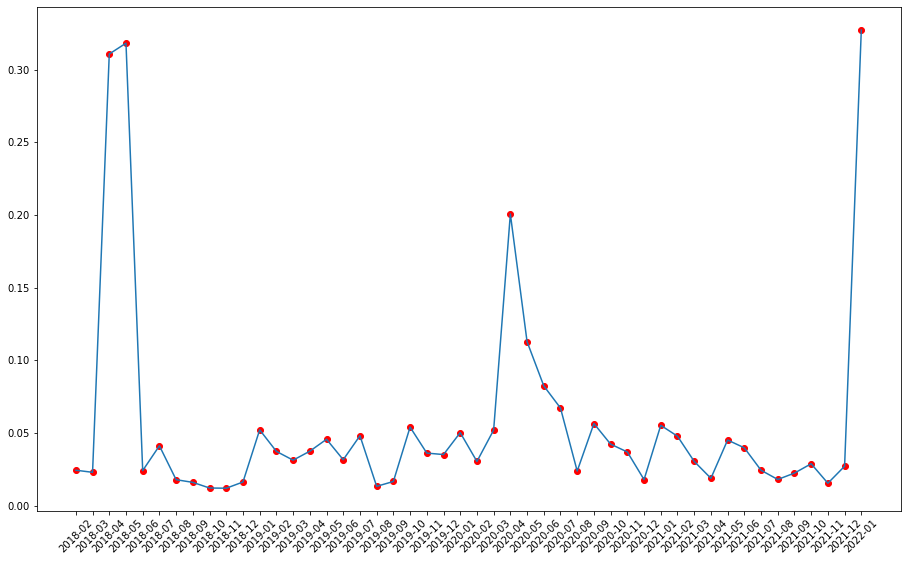

In [64]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

ax.plot(jensenshannon_dis['date_i'], jensenshannon_dis['jensenshannon'], 'ro')
ax.plot(jensenshannon_dis['date_i'], jensenshannon_dis['jensenshannon'], '-')
#ax.bar(jensenshannon_dis['date_i'], jensenshannon_dis['jensenshannon'])
ax.set_xticklabels(jensenshannon_dis['date_f'], rotation=45)
plt.show()

### Cholera, skin damage chicunguya, malaria, sika

In [65]:
def temp_funct(x):
    x = x[0:3]
    if x in ['P35']:
        return 'Zika'
    elif x in ['P37', 'B50', 'B51', 'B52', 'B53', 'B54']:
        return 'Malaria'
    elif x in ['A00']:
        return 'Cholera'
    elif x in ['A92']:
        return 'Chikungunya '
    else:
        return 'Other'
    return 'Other'

In [71]:
data_temp = all_data
data_temp['INFECTIONS_DISEASE'] = data_temp['DIAGNOSIS_ID'].apply(lambda x:temp_funct(x))
data_temp = data_temp[data_temp['INFECTIONS_DISEASE']!='Other']

data_temp = data_temp.groupby(['YEAR','INFECTIONS_DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.sort_values(by=['YEAR', 'INFECTIONS_DISEASE']).reset_index()
data_temp = data_temp.pivot(index =['YEAR'], columns = 'INFECTIONS_DISEASE')
data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)
data_temp.head()

INFECTIONS_DISEASE,Chikungunya,Cholera,Malaria,Zika
YEAR,,,,
2018,45.0,251.0,929.0,206.0
2019,50.0,692.0,615.0,149.0
2020,9.0,67.0,195.0,41.0
2021,7.0,206.0,241.0,90.0
2022,0.0,0.0,4.0,4.0


Text(0.5, 1.0, 'Qty of diseases by year')

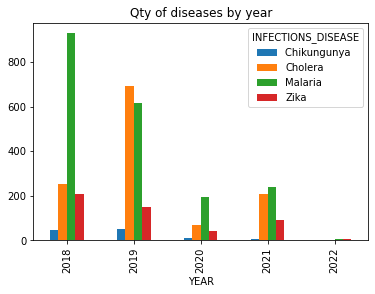

In [72]:
abc = data_temp.plot(kind="bar", stacked=False)
#abc.yaxis.set_major_formatter(millions)
abc.set_title('Qty of diseases by year')

### Ask the codes Pneumonia, influenza.
    - ICD-10-CM Code for Pneumonia, unspecified organism J18.9
    - Influenza and pneumonia (J09-J18)
    - https://icd.who.int/browse10/2019/en#/J09-J18

In [74]:
def temp_funct(x):
    x = x[0:3]
    if x >= 'J09' and x < 'J12':
        return 'Influenza'
    elif x >= 'J12' and x < 'J19':
        return 'Pneumonia'
    else:
        return 'Other'
    return 'Other'

data_temp = all_data
data_temp['LUNG_DISEASE'] = data_temp['DIAGNOSIS_ID'].apply(lambda x:temp_funct(x))
data_temp = data_temp[data_temp['LUNG_DISEASE']!='Other']

data_temp = data_temp.groupby(['YEAR','LUNG_DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.sort_values(by=['YEAR', 'LUNG_DISEASE']).reset_index()
data_temp = data_temp.pivot(index =['YEAR'], columns = 'LUNG_DISEASE')
data_temp.columns = data_temp.columns.droplevel()
data_temp.fillna(0, inplace = True)
data_temp.head()

LUNG_DISEASE,Influenza,Pneumonia
YEAR,,
2018,2949,59900
2019,2196,33149
2020,471,44016
2021,750,61069
2022,76,1392


Text(0.5, 1.0, 'Qty of diseases by year')

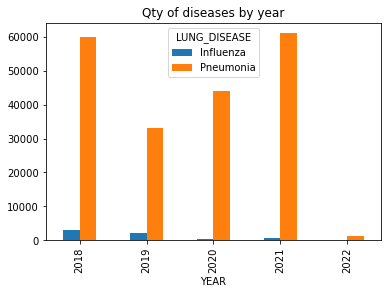

In [75]:
abc = data_temp.plot(kind="bar", stacked=False, figsize=(12,7))
#abc.yaxis.set_major_formatter(millions)
abc.set_title('Qty of diseases by year')

### Years VS (2018-2019)

In [174]:
# data_temp = all_data.groupby(['DATE','SEX']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
# data_temp = data_temp.reset_index()

date_uniques = all_data['MONTH'].unique()

data_temp_m = all_data[all_data['YEAR']==2018]
data_temp_m = data_temp_m.groupby(['MONTH']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp_m = data_temp_m.rename(columns={'QTY_PEOPLE_SERVED': 'People_served_2018'})

data_temp_f = all_data[all_data['YEAR']==2019]
data_temp_f = data_temp_f.groupby(['MONTH']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp_f = data_temp_f.rename(columns={'QTY_PEOPLE_SERVED': 'People_served_2019'})

data_temp_g = all_data[all_data['YEAR']==2020]
data_temp_g = data_temp_g.groupby(['MONTH']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp_g = data_temp_g.rename(columns={'QTY_PEOPLE_SERVED': 'People_served_2020'})

data_temp_l = all_data[all_data['YEAR']==2021]
data_temp_l = data_temp_l.groupby(['MONTH']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp_l = data_temp_l.rename(columns={'QTY_PEOPLE_SERVED': 'People_served_2021'})

object_df = pd.merge(data_temp_m, data_temp_f, how='inner', on=('MONTH'))
object_df = pd.merge(object_df, data_temp_g, how='inner', on=('MONTH'))
object_df = pd.merge(object_df, data_temp_l, how='inner', on=('MONTH'))

object_df.head()

,People_served_2018,People_served_2019,People_served_2020,People_served_2021
MONTH,,,,
1,1865409,2310921,1026985,1083959
2,1794168,2458457,1134259,917967
3,1906675,2495033,745111,1108888
4,2983260,2397163,192893,1114314
5,1976273,1951960,249910,1143498


Text(0.5, 1.0, 'Qty of diseases by month')

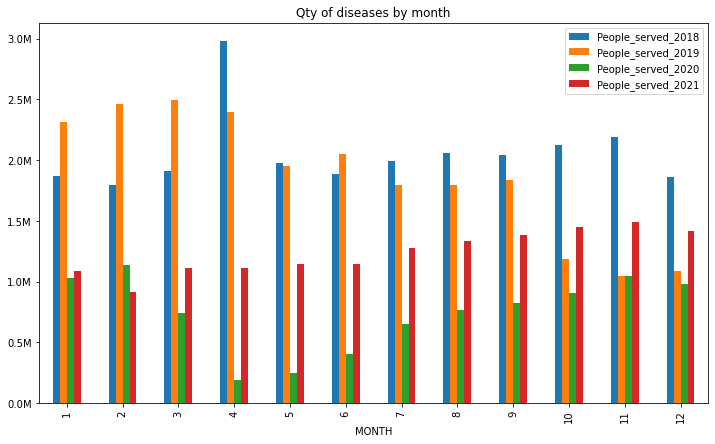

In [175]:
abc = object_df.plot(kind="bar", stacked=False, figsize=(12,7))
abc.yaxis.set_major_formatter(millions)
abc.set_title('Qty of diseases by month')

In [176]:
all_data.head()

,YEAR,MONTH,UBIGEO,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CO_IPRESS,NAME,...,CATEGORY2,DISEASE_GROUP,DATE,TYPE,DIGNOSTICO,IS_LIMA,DENTAL_DISEASE,SKIN_DISEASE,INFECTIONS_DISEASE,LUNG_DISEASE
0,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True,False,Other,Other,Other
1,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True,False,Other,Other,Other
2,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True,False,Other,Other,Other
3,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True,False,Other,Other,Other
4,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,...,II,"Abnormal clinical and laboratory symptoms, sig...",2018-01-01,Outpatient Consultation,NaN,True,False,Other,Other,Other


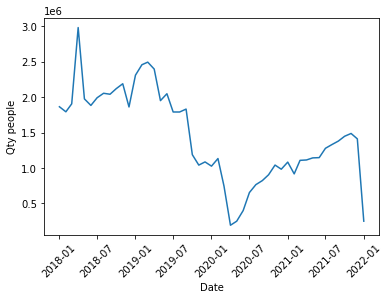

In [252]:
#all_data['DATE'] = pd.to_datetime(all_data['DATE'], format='%Y-%m-%d')

data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

plt.ylabel('Qty people')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(data_temp['DATE'], data_temp['sum'])

data_temp = data_temp[(data_temp['DATE']<'2022')]
data_temp_mean = data_temp[~(data_temp['DATE']>='2020-03')]
data_temp = data_temp[(data_temp['DATE']>='2020-03')]


Media: 1893486.6153846155


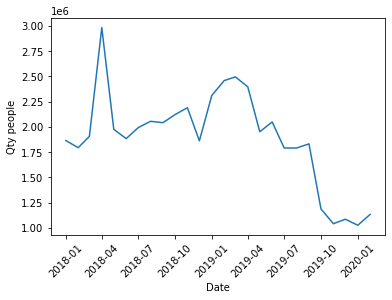

In [253]:
#data_temp_mean
plt.ylabel('Qty people')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(data_temp_mean['DATE'], data_temp_mean['sum'])

media = data_temp_mean['sum'].mean()
print('Media:',media)

In [254]:
data_temp_mean.describe()

,sum,count
count,2.600000e+01,26.000000
mean,1.893487e+06,6689.769231
std,4.802461e+05,204.040252
min,1.026985e+06,6133.000000
25%,1.792249e+06,6688.500000
50%,1.929318e+06,6765.500000
75%,2.105010e+06,6808.250000
max,2.983260e+06,6893.000000


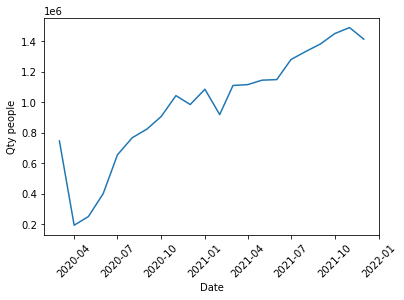

In [255]:
data_temp = data_temp[(data_temp['DATE']<'2022')]
data_temp = data_temp[(data_temp['DATE']>='2020-03')]

plt.ylabel('Qty people')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(data_temp['DATE'], data_temp['sum'])


In [256]:
data_temp = data_temp[['DATE','sum']]
data_temp = data_temp.reset_index(drop=True)
data_temp.set_index('DATE', inplace=True)
data_temp.head()

,sum
DATE,
2020-03-01,745111
2020-04-01,192893
2020-05-01,249910
2020-06-01,399843
2020-07-01,654142


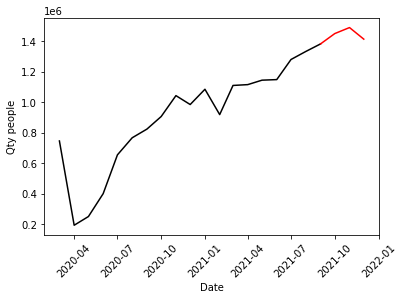

In [273]:
train = data_temp[data_temp.index < "2021-10-01"]
test = data_temp[data_temp.index >= "2021-09"]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Qty people')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

In [274]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

y = data_temp['sum']
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

C:\Users\johnk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\johnk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\johnk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


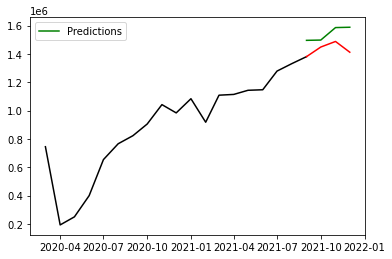

In [275]:
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.legend()

### como la demanda ha cambiado por el covid

In [ ]:
data_temp.columns

In [ ]:
plt.hist(data_temp['CATEGORY'])

In [ ]:
PARAMETER = 'CATEGORY'
data_temp = data_temp[data_temp['IS_LIMA']==True]

data_temp = data_temp.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

In [ ]:
all_data.head()

In [ ]:
### Hospital by category

In [ ]:
data_temp = data_temp[data_temp['IS_LIMA']==True]

data_temp = data_temp.groupby(['DATE', 'CATEGORY', 'NAME']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE', 'CATEGORY']).agg({ 'NAME': "count"})
data_temp = data_temp.reset_index()

In [ ]:
data_temp.head()

In [ ]:
# TODO 
# - Check outliers systematically (for each variable mean and std dev to mark points outside the the std dev) For unique giasnosis and served people
# - Hospital  per category type
# - Cholera, skin damage chicunguya, malaria, sika (look for)
# - Understand what have changed in data
# - Predict when the Peruvian health system will recover using  individuals served by month 
# - Croos by gender recovery health system using  individuals served by month 
# - Check dental diagnosis over years
# - Unique diagnosis per category type per year
# - How demand patterns change during covid-19


In [ ]:
all_data.head()

In [ ]:
abc  = all_data['DISEASE_GROUP'].unique()
abc

In [ ]:
len(abc)

In [ ]:


#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html

In [ ]:
private vs public using boostrapo
same color for all desisises
for all categories (public and private)
repet these graph for every, histogram for each category (*)
only for hospital that have diagnostics
start to agg, grup bi diagnostics


for category 2 ans 3 normalize 

build forecast for all categories


